In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import chi2
from arch import arch_model

In [3]:
# Wczytanie danych z plików CSV
wig20 = pd.read_csv('wig20.csv')
nasdaq = pd.read_csv('nasdaq.csv')
nvidia = pd.read_csv('nvidia.csv')
sp500 = pd.read_csv('s&p500.csv')
apple = pd.read_csv('apple.csv')
dowjones30 = pd.read_csv('dowjones30.csv')
eurusd = pd.read_csv('eurusd.csv')
gbpusd = pd.read_csv('gbpusd.csv')
gbrindx = pd.read_csv('gbrindx.csv')
xauusd = pd.read_csv('xauusd.csv')

In [4]:
# Funkcja do obliczenia logarytmicznych stóp zwrotu
def calculate_log_returns(df, column='Zamkniecie'):
    df['Zlogarytmowana stopa zwrotu'] = np.log(df[column] / df[column].shift(1))
    return df

# Lista instrumentów
instruments = [wig20, nasdaq, nvidia, sp500, apple, dowjones30, eurusd, gbpusd, gbrindx, xauusd]
instrument_names = ['wig20', 'nasdaq', 'nvidia', 'sp500', 'apple', 'dowjones30', 'eurusd', 'gbpusd', 'gbrindx', 'xauusd']

# Przetwarzanie danych dla każdego instrumentu
for i, df in enumerate(instruments):
    df = calculate_log_returns(df)
    df.dropna(inplace=True)
    df['ZSZ100'] = df['Zlogarytmowana stopa zwrotu'] * 100 # Pomnożenie zlogarytmowanej stopy zwrotu razy 100, gdyż model miał problemy z obliczeniami tak małych wartości z kolumny "Zlogarytmowana stopa zwrotu"
    instruments[i] = df

In [5]:
wig20

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,1818.20,1818.20,1784.10,1796.60,8762754.0,-0.030856,-3.085599
2,2000-01-05,1739.00,1787.10,1739.00,1777.00,9760796.0,-0.010969,-1.096944
3,2000-01-06,1776.20,1835.60,1765.00,1832.10,7560972.0,0.030536,3.053630
4,2000-01-07,1867.00,1946.40,1867.00,1933.20,15747541.0,0.053714,5.371381
5,2000-01-10,1968.80,2041.90,1968.80,2000.80,16363578.0,0.034370,3.437044
...,...,...,...,...,...,...,...,...
6253,2024-12-19,2201.10,2227.86,2196.85,2225.51,27362416.0,-0.000481,-0.048067
6254,2024-12-20,2217.49,2219.00,2179.88,2200.39,37604945.0,-0.011351,-1.135149
6255,2024-12-23,2217.40,2227.77,2201.05,2202.17,16626488.0,0.000809,0.080862
6256,2024-12-27,2205.98,2207.75,2186.66,2204.19,9790987.0,0.000917,0.091686


In [6]:
nasdaq

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,4020.00,4073.25,3898.23,3901.69,1.406011e+09,-0.057146,-5.714603
2,2000-01-05,3854.35,3924.21,3734.87,3877.54,1.614173e+09,-0.006209,-0.620886
3,2000-01-06,3834.44,3868.76,3715.62,3727.13,1.486438e+09,-0.039562,-3.956243
4,2000-01-07,3711.09,3882.67,3711.09,3882.62,1.520485e+09,0.040872,4.087168
5,2000-01-10,4002.23,4072.36,3958.83,4049.67,1.573290e+09,0.042125,4.212521
...,...,...,...,...,...,...,...,...
6286,2024-12-24,19818.48,20031.13,19813.77,20031.13,2.932500e+09,0.013381,1.338094
6287,2024-12-26,19979.25,20070.08,19888.11,20020.36,4.078057e+09,-0.000538,-0.053781
6288,2024-12-27,19896.77,19904.77,19553.40,19722.03,5.000352e+09,-0.015013,-1.501347
6289,2024-12-30,19460.41,19622.93,19342.51,19486.79,5.505574e+09,-0.011999,-1.199948


In [7]:
nvidia

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,0.087840,0.088059,0.082566,0.087151,8.233332e+07,-0.025904,-2.590352
2,2000-01-05,0.084634,0.086002,0.083036,0.084174,5.151396e+07,-0.034747,-3.474682
3,2000-01-06,0.084174,0.084174,0.075455,0.078671,3.291229e+07,-0.067612,-6.761242
4,2000-01-07,0.078441,0.080958,0.077293,0.080039,2.001418e+07,0.017242,1.724185
5,2000-01-10,0.080269,0.086002,0.078901,0.082566,6.608640e+07,0.031081,3.108134
...,...,...,...,...,...,...,...,...
6284,2024-12-24,140.000000,141.900000,138.650000,140.220000,1.051570e+08,0.003930,0.393012
6285,2024-12-26,139.700000,140.850000,137.730000,139.930000,1.165191e+08,-0.002070,-0.207032
6286,2024-12-27,138.550000,139.020000,134.710000,137.010000,1.705826e+08,-0.021088,-2.108838
6287,2024-12-30,134.830000,140.270000,134.020000,137.490000,1.677347e+08,0.003497,0.349727


In [8]:
sp500

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,1455.22,1455.22,1397.43,1399.42,5.605556e+08,-0.039099,-3.909923
2,2000-01-05,1399.42,1413.27,1377.68,1402.11,6.030556e+08,0.001920,0.192038
3,2000-01-06,1402.11,1411.90,1392.10,1403.45,6.068333e+08,0.000955,0.095525
4,2000-01-07,1403.45,1441.47,1400.73,1441.47,6.806667e+08,0.026730,2.672994
5,2000-01-10,1441.47,1464.36,1441.47,1457.60,5.915556e+08,0.011128,1.112782
...,...,...,...,...,...,...,...,...
6284,2024-12-24,5984.63,6040.10,5981.44,6040.04,1.133217e+09,0.010982,1.098220
6285,2024-12-26,6024.97,6049.75,6007.37,6037.59,1.506251e+09,-0.000406,-0.040571
6286,2024-12-27,6006.17,6006.17,5932.95,5970.84,1.817798e+09,-0.011117,-1.111730
6287,2024-12-30,5920.67,5940.79,5869.16,5906.94,1.943393e+09,-0.010760,-1.075969


In [9]:
apple

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,0.816211,0.834185,0.763074,0.772753,6.067407e+08,-0.087916,-8.791574
2,2000-01-05,0.782234,0.833594,0.776506,0.784013,9.216628e+08,0.014466,1.446614
3,2000-01-06,0.800210,0.806827,0.716259,0.716259,9.094082e+08,-0.090384,-9.038377
4,2000-01-07,0.727418,0.761494,0.720209,0.750529,5.455865e+08,0.046736,4.673646
5,2000-01-10,0.769098,0.770877,0.714481,0.737099,5.980802e+08,-0.018056,-1.805608
...,...,...,...,...,...,...,...,...
6284,2024-12-24,255.490000,258.210000,255.290000,258.200000,2.323470e+07,0.011413,1.141267
6285,2024-12-26,258.190000,260.100000,257.630000,259.020000,2.726298e+07,0.003171,0.317080
6286,2024-12-27,257.830000,258.700000,253.060000,255.590000,4.235532e+07,-0.013331,-1.333068
6287,2024-12-30,252.230000,253.500000,250.750000,252.200000,3.555754e+07,-0.013352,-1.335217


In [10]:
dowjones30

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,11349.80,11350.10,10986.50,10997.90,178357418.0,-0.032174,-3.217397
2,2000-01-05,10989.40,11215.10,10938.70,11122.70,203266571.0,0.011284,1.128372
3,2000-01-06,11113.40,11313.50,11098.50,11253.30,176642517.0,0.011673,1.167335
4,2000-01-07,11247.10,11528.10,11239.90,11522.60,184926808.0,0.023649,2.364891
5,2000-01-10,11532.50,11638.30,11532.50,11572.20,168229080.0,0.004295,0.429535
...,...,...,...,...,...,...,...,...
6284,2024-12-24,42916.48,43297.65,42871.76,43297.03,154320664.0,0.009050,0.905022
6285,2024-12-26,43201.85,43373.98,43115.09,43325.80,201741006.0,0.000664,0.066426
6286,2024-12-27,43142.37,43238.85,42761.56,42992.21,245795211.0,-0.007729,-0.772936
6287,2024-12-30,42863.86,42863.86,42263.51,42573.73,272043785.0,-0.009782,-0.978154


In [11]:
eurusd

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,1.02400,1.03430,1.02100,1.03080,0.004473,0.447254
2,2000-01-05,1.02930,1.04020,1.02800,1.03140,0.000582,0.058190
3,2000-01-06,1.03200,1.04140,1.02700,1.03190,0.000485,0.048466
4,2000-01-07,1.03240,1.03300,1.02500,1.02890,-0.002911,-0.291149
5,2000-01-10,1.02850,1.03000,1.02100,1.02530,-0.003505,-0.350502
...,...,...,...,...,...,...,...
6478,2024-12-25,1.04060,1.04073,1.03976,1.04012,0.000346,0.034617
6479,2024-12-26,1.04026,1.04299,1.03906,1.04239,0.002180,0.218006
6480,2024-12-27,1.04236,1.04439,1.04052,1.04257,0.000173,0.017267
6481,2024-12-30,1.04325,1.04583,1.03718,1.04055,-0.001939,-0.193940


In [12]:
gbpusd

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,1.63690,1.64100,1.63110,1.63640,-0.000306,-0.030550
2,2000-01-05,1.63640,1.64470,1.63480,1.64150,0.003112,0.311175
3,2000-01-06,1.64150,1.65070,1.64070,1.64640,0.002981,0.298063
4,2000-01-07,1.64640,1.64960,1.63590,1.63830,-0.004932,-0.493197
5,2000-01-10,1.63830,1.63910,1.63210,1.63640,-0.001160,-0.116041
...,...,...,...,...,...,...,...
6473,2024-12-25,1.25375,1.25575,1.25220,1.25491,0.002162,0.216185
6474,2024-12-26,1.25487,1.25491,1.25013,1.25261,-0.001834,-0.183448
6475,2024-12-27,1.25257,1.25924,1.25052,1.25798,0.004278,0.427789
6476,2024-12-30,1.25822,1.26074,1.25070,1.25433,-0.002906,-0.290569


In [13]:
gbrindx

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,37.0600,37.1100,37.0000,37.0600,-0.001887,-0.188705
2,2000-01-05,37.1200,37.2100,37.1000,37.1700,0.002964,0.296376
3,2000-01-06,37.3500,37.4500,37.3400,37.4000,0.006169,0.616872
4,2000-01-07,37.3200,37.3600,37.2100,37.2400,-0.004287,-0.428725
5,2000-01-10,37.2700,37.2800,37.2000,37.2500,0.000268,0.026849
...,...,...,...,...,...,...,...
6473,2024-12-25,28.3441,28.3583,28.2755,28.3395,0.002013,0.201335
6474,2024-12-26,28.3296,28.3432,28.2597,28.2934,-0.001628,-0.162803
6475,2024-12-27,28.2922,28.4326,28.2569,28.4244,0.004619,0.461937
6476,2024-12-30,28.4148,28.4576,28.2748,28.3217,-0.003620,-0.361964


In [14]:
xauusd

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Zlogarytmowana stopa zwrotu,ZSZ100
1,2000-01-04,286.75,286.750,279.950,282.380,-0.023173,-2.317301
2,2000-01-05,282.27,283.450,279.750,280.850,-0.005433,-0.543296
3,2000-01-06,280.80,281.750,279.450,281.450,0.002134,0.213409
4,2000-01-07,281.25,283.300,280.880,281.750,0.001065,0.106534
5,2000-01-10,281.25,282.500,281.120,281.600,-0.000533,-0.053253
...,...,...,...,...,...,...,...
6429,2024-12-24,2612.62,2621.535,2610.235,2616.180,0.001237,0.123730
6430,2024-12-26,2615.97,2639.145,2615.340,2633.795,0.006711,0.671053
6431,2024-12-27,2632.59,2638.275,2611.825,2615.555,-0.006949,-0.694946
6432,2024-12-30,2620.05,2628.125,2596.185,2605.965,-0.003673,-0.367326


In [15]:
# Statystyki opisowe dla zlogarytmowanych stóp zwrotu
log_returns_stats = {
    'Instrument': instrument_names,
    'Mean': [df['ZSZ100'].mean() for df in instruments],
    'Median': [df['ZSZ100'].median() for df in instruments],
    'Std Dev': [df['ZSZ100'].std() for df in instruments],
    'CV (%)': [df['ZSZ100'].std() / abs(df['ZSZ100'].mean()) for df in instruments],
    'Min': [df['ZSZ100'].min() for df in instruments],
    'Max': [df['ZSZ100'].max() for df in instruments]
}

# Tworzenie DataFrame z wynikami
log_returns_stats_df = pd.DataFrame(log_returns_stats)
log_returns_stats_df

,Instrument,Mean,Median,Std Dev,CV (%),Min,Max
0,wig20,0.002686,0.006456,1.493668,556.080730,-14.245579,8.154839
1,nasdaq,0.024517,0.091575,1.570485,64.057457,-13.149061,13.254645
2,nvidia,0.116320,0.131500,3.728904,32.057231,-43.479930,35.413521
3,sp500,0.022212,0.060002,1.223395,55.078649,-12.765214,10.957196
4,apple,0.090538,0.093590,2.524111,27.879074,-73.079551,12.999649
5,dowjones30,0.021003,0.049764,1.163299,55.387379,-13.841813,10.764325
6,eurusd,0.000137,0.010202,0.586486,4282.593974,-2.947990,3.415720
7,gbpusd,-0.004148,0.001576,0.582103,140.323479,-9.505010,3.130041
8,gbrindx,-0.004188,0.007846,0.485637,115.951836,-9.282177,3.164439
9,xauusd,0.034296,0.045767,1.045086,30.472673,-9.241378,10.050047


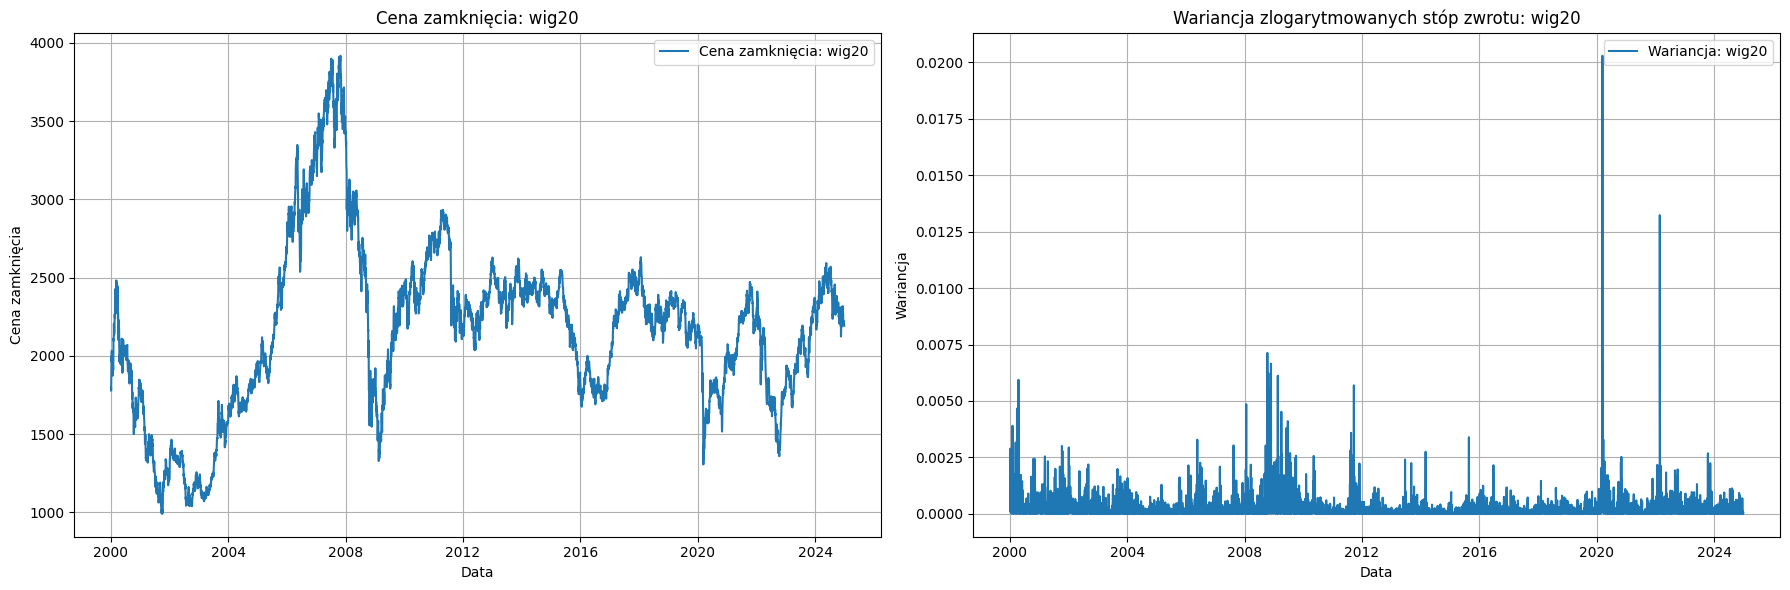

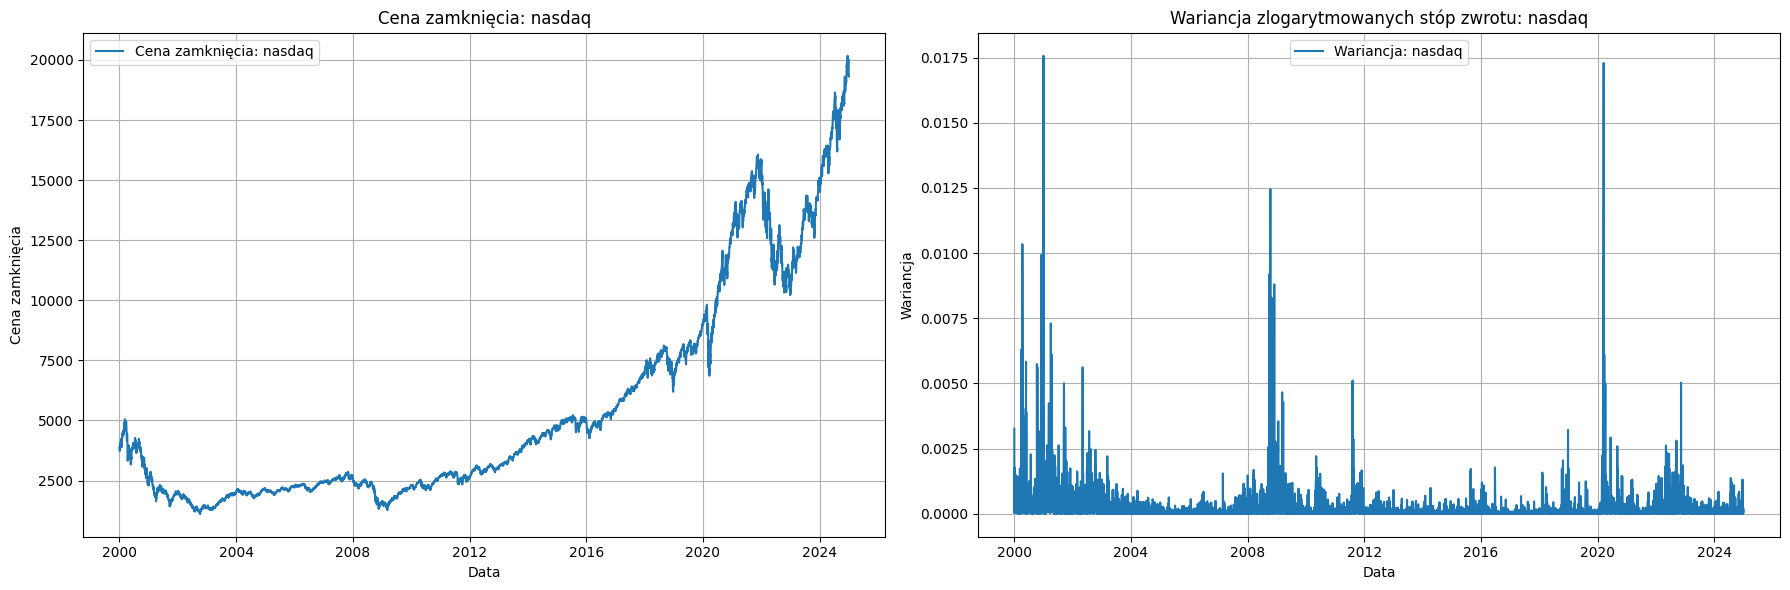

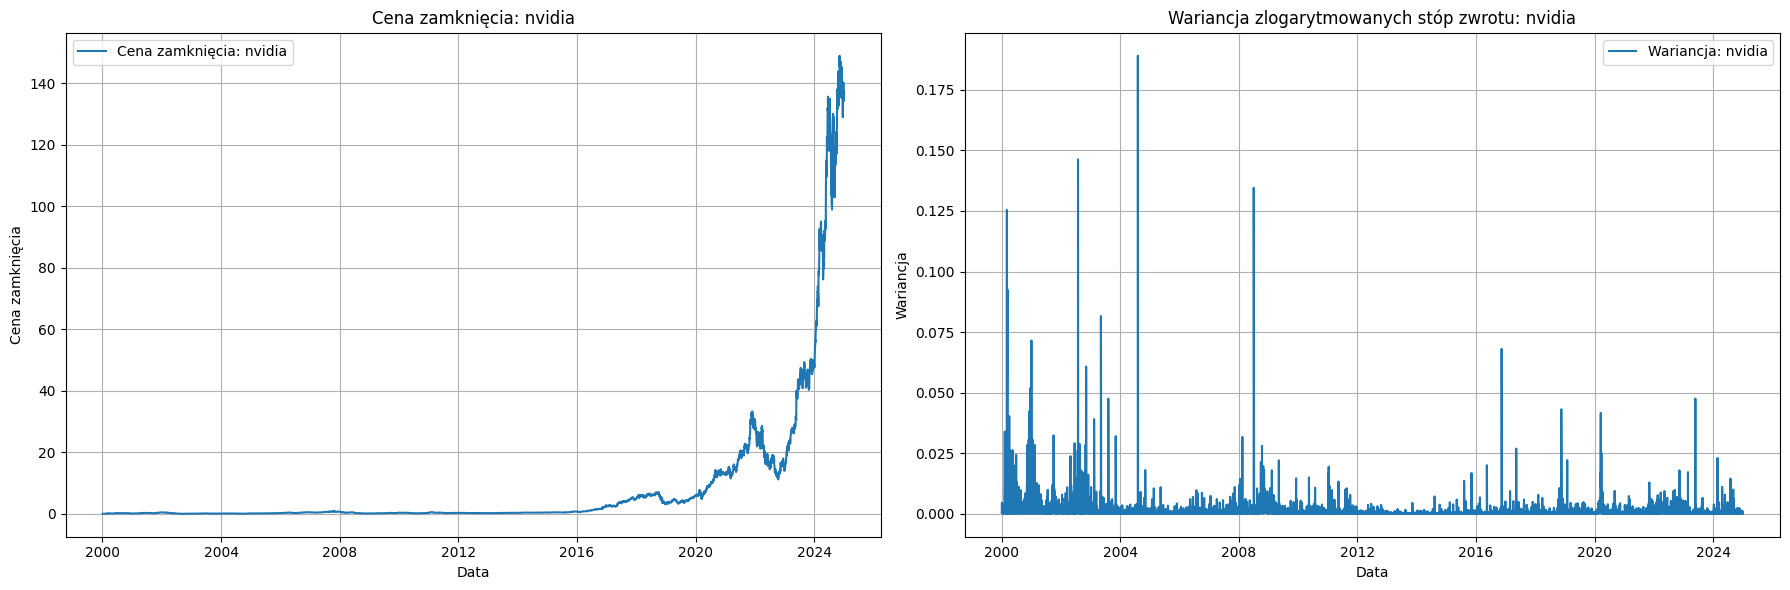

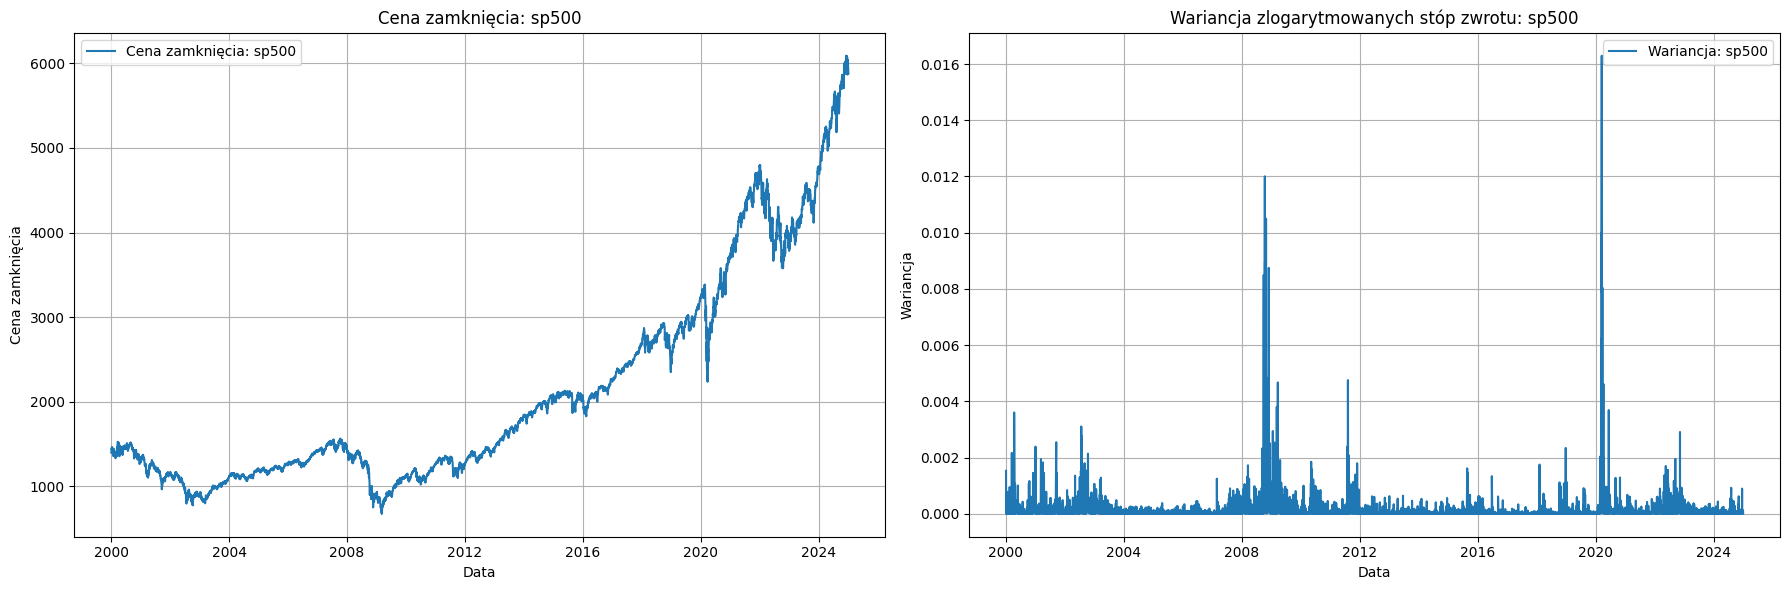

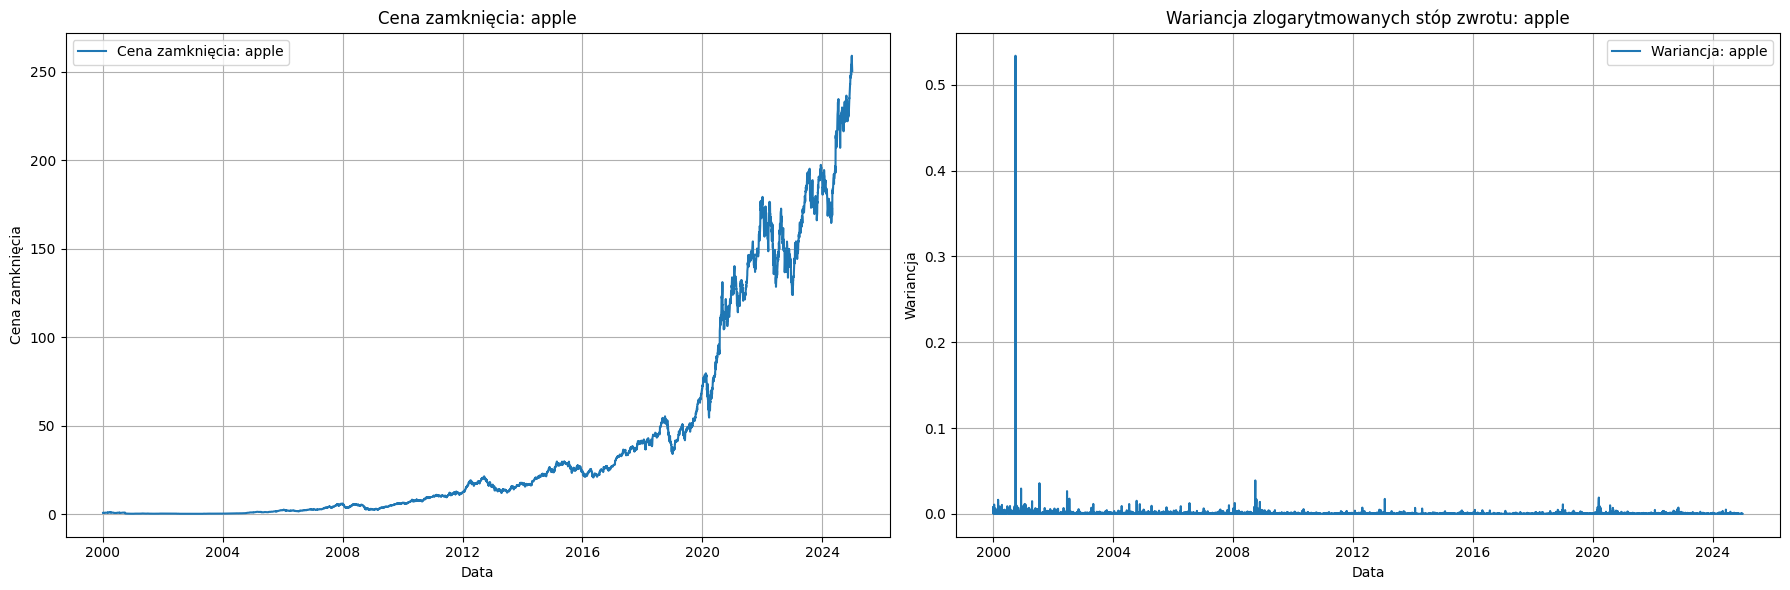

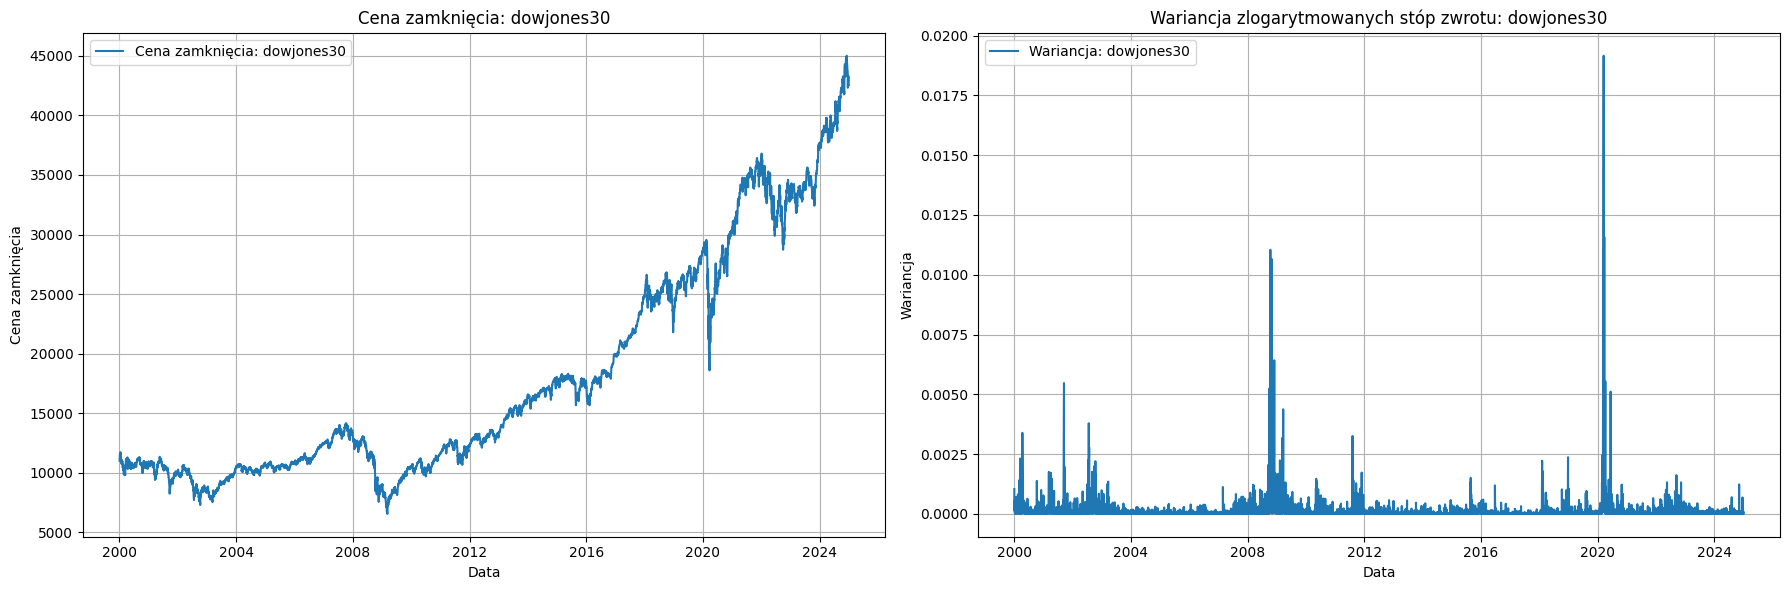

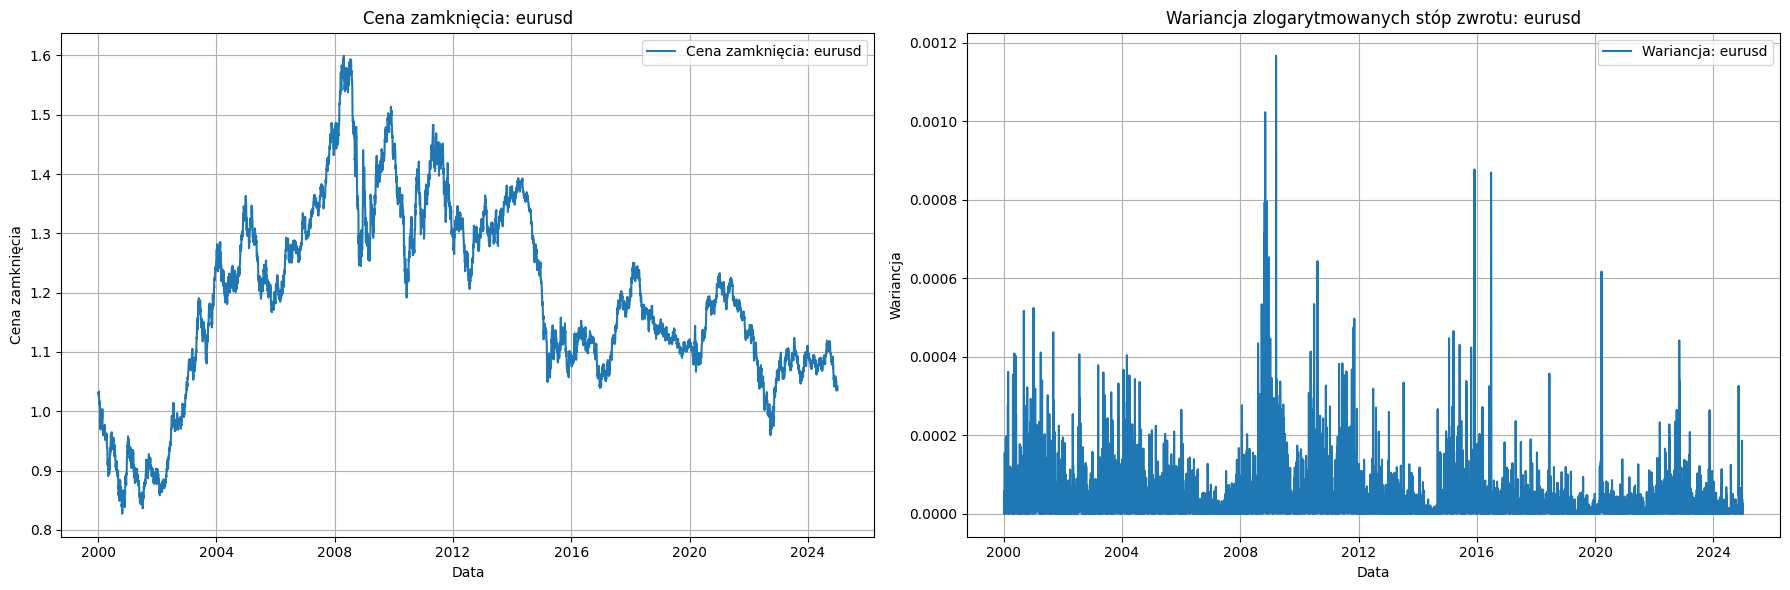

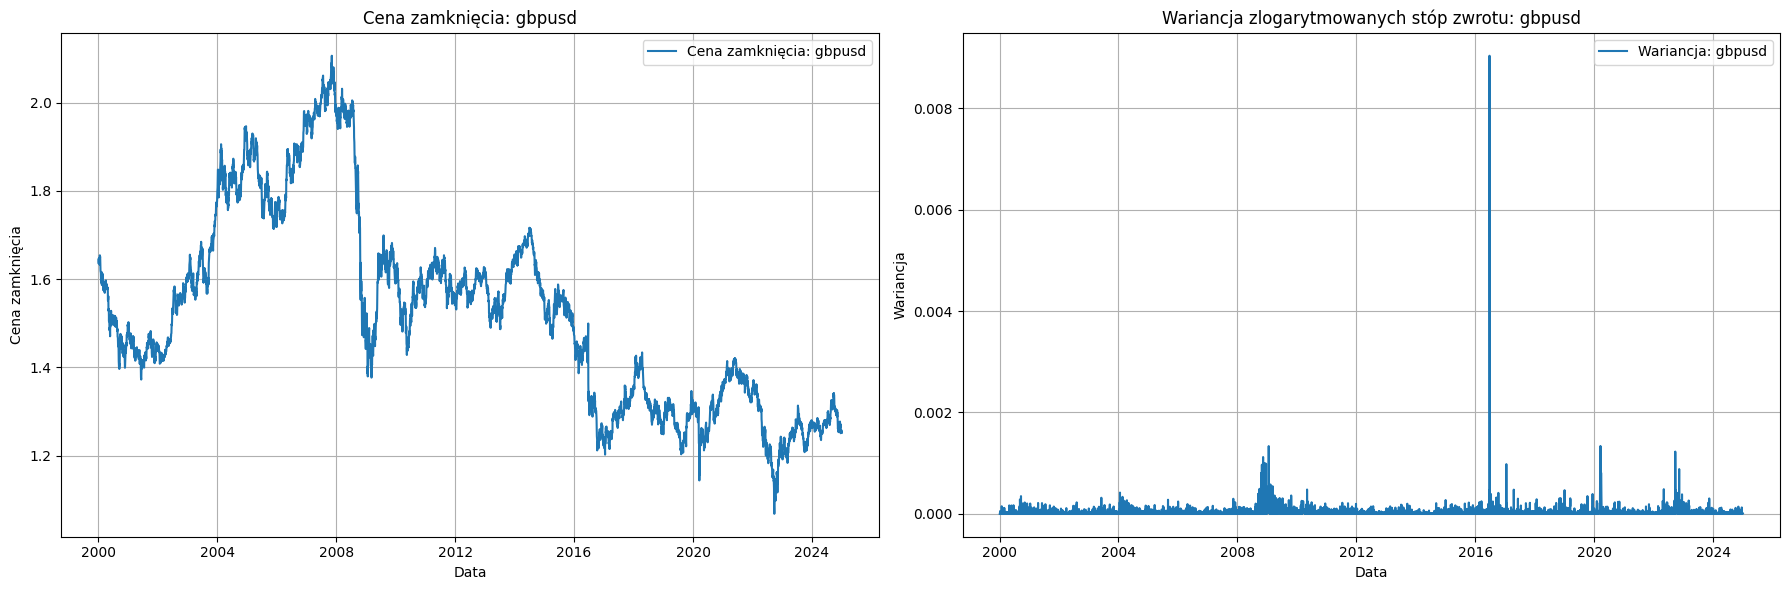

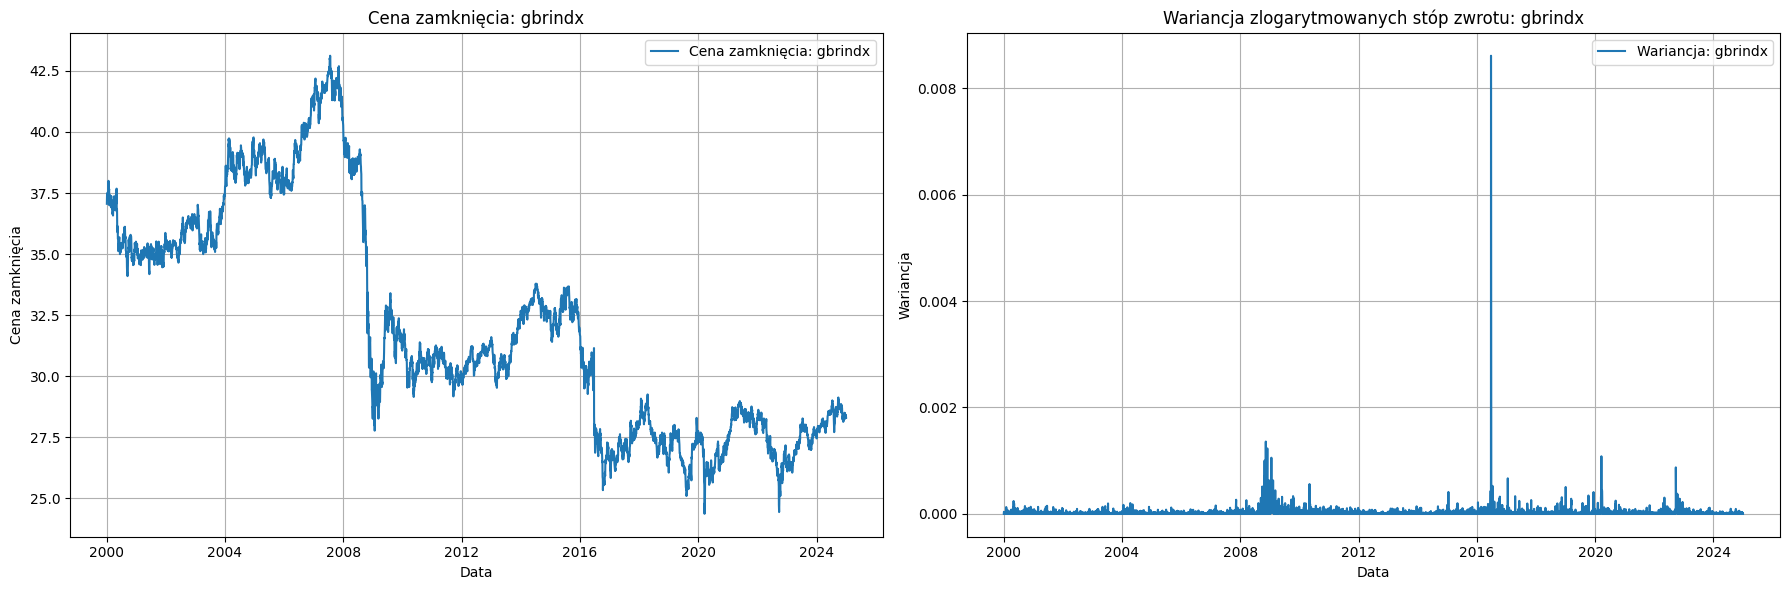

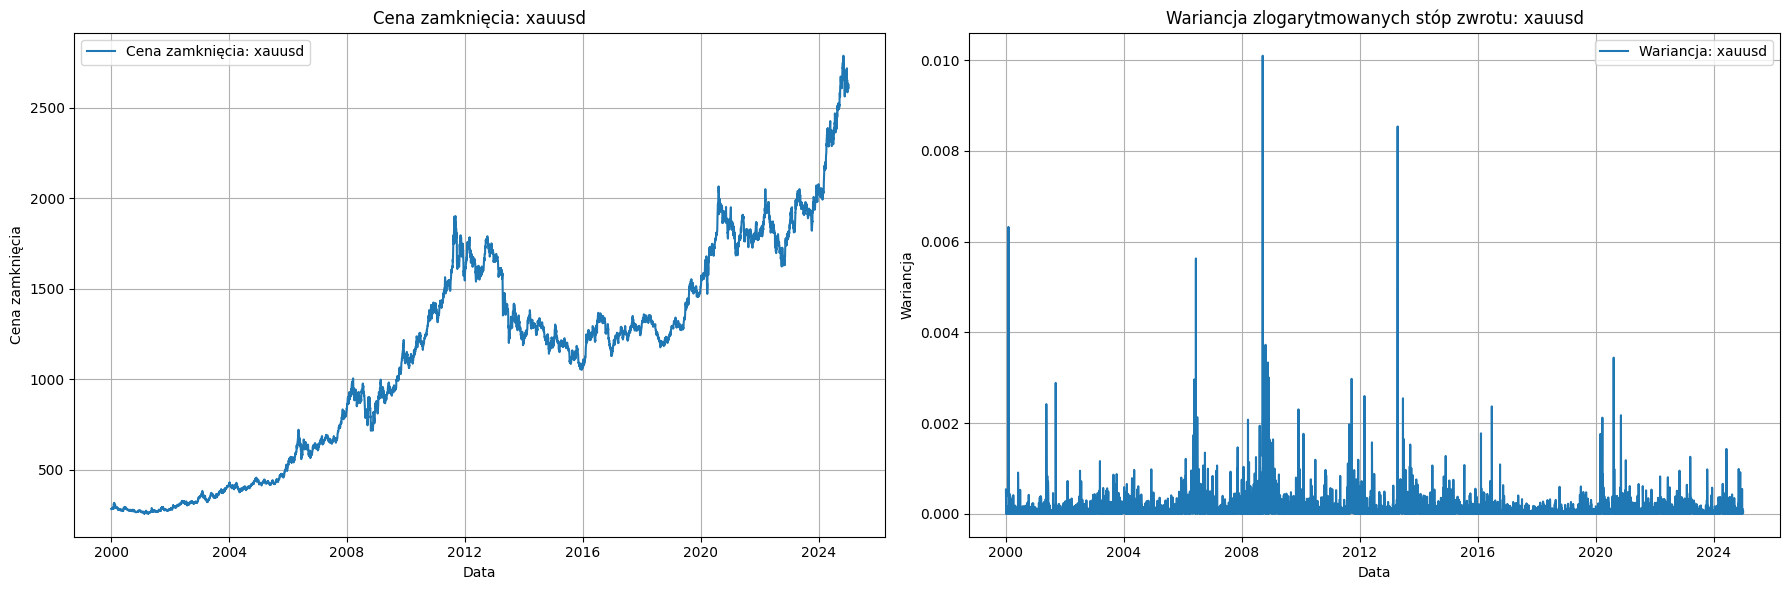

In [16]:
# Funkcja do rysowania cen zamknięcia i wariancji na zestawionych wykresach
def plot_closing_prices_and_variance(dataframes, instrument_names):
    for df, name in zip(dataframes, instrument_names):
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Wykres cen zamknięcia
        axes[0].plot(pd.to_datetime(df['Data']), df['Zamkniecie'], label=f"Cena zamknięcia: {name}")
        axes[0].set_title(f"Cena zamknięcia: {name}")
        axes[0].set_xlabel("Data")
        axes[0].set_ylabel("Cena zamknięcia")
        axes[0].legend()
        axes[0].grid()

        # Wykres wariancji
        axes[1].plot(pd.to_datetime(df['Data']), df['Zlogarytmowana stopa zwrotu'] ** 2, label=f"Wariancja: {name}")
        axes[1].set_title(f"Wariancja zlogarytmowanych stóp zwrotu: {name}")
        axes[1].set_xlabel("Data")
        axes[1].set_ylabel("Wariancja")
        axes[1].legend()
        axes[1].grid()

        plt.tight_layout()
        plt.show()

# Wykresy cen zamknięcia na osobnych obrazkach
plot_closing_prices_and_variance(instruments, instrument_names)

In [17]:
# Funkcja do testowania autokorelacji kwadratów reszt
def test_autocorrelation_squared_returns(df, column='ZSZ100', lags=5):
    squared_returns = df[column] ** 2
    acf_values, q_stat, p_values = acf(squared_returns, fft=False, qstat=True, nlags=lags)
    return {
        'Q Stat': q_stat[-1],
        'p-value': p_values[-1]
    }

# Przeprowadzanie testu na autokorelację kwadratów reszt
autocorr_test_results = {
    'Instrument': instrument_names,
    'Q Stat': [],
    'p-value': []
}

for df, name in zip(instruments, autocorr_test_results['Instrument']):
    result = test_autocorrelation_squared_returns(df)
    autocorr_test_results['Q Stat'].append(result['Q Stat'])
    autocorr_test_results['p-value'].append(result['p-value'])

# Tworzenie DataFrame z wynikami testu
autocorr_test_results_df = pd.DataFrame(autocorr_test_results)
autocorr_test_results_df

,Instrument,Q Stat,p-value
0,wig20,977.456883,4.562809e-209
1,nasdaq,2512.174079,0.000000e+00
2,nvidia,408.252005,4.938582e-86
3,sp500,3542.569918,0.000000e+00
4,apple,11.051396,5.037042e-02
5,dowjones30,3601.900607,0.000000e+00
6,eurusd,627.227781,2.643931e-133
7,gbpusd,269.084046,4.401750e-56
8,gbrindx,212.719072,5.386159e-44
9,xauusd,381.839167,2.430667e-80


In [18]:
# Test Engle’a (ARCH-LM)
arch_test_results = {
    'Instrument': [],
    'LM Statistic': [],
    'LM p-value': [],
    'F Statistic': [],
    'F p-value': []
}

for name, df in zip(instrument_names, instruments):
    df_lm = df.copy(deep=True)  # Tworzenie pełnej kopii zbioru danych w każdej iteracji dla wykonania na nim testu Engle'a (ARCH-LM) dla reszt z modelu AR(1)
    
    # Tworzymy opóźnioną zmienną
    df_lm['lag_return'] = df_lm['ZSZ100'].shift(1)
    df_lm = df_lm.dropna()
    
    # Zmienna zależna i objaśniająca (AR(1))
    y = df_lm['ZSZ100']
    X = sm.add_constant(df_lm['lag_return'])  # dodanie wyrazu wolnego

    # Estymacja modelu AR(1) za pomocą OLS
    model = sm.OLS(y, X).fit()
    
    # Reszty z modelu
    residuals = model.resid

    # Przeprowadzenie testu Engle’a na resztach
    test_arch = het_arch(residuals, nlags=5)
    # Zwraca: (LM stat, LM p-value, F stat, F p-value)
    lm_stat, lm_pval, f_stat, f_pval = test_arch

    # Zapis wyników do słownika
    arch_test_results['Instrument'].append(name)
    arch_test_results['LM Statistic'].append(lm_stat)
    arch_test_results['LM p-value'].append(lm_pval)
    arch_test_results['F Statistic'].append(f_stat)
    arch_test_results['F p-value'].append(f_pval)

# Tworzymy DataFrame z wynikami testu Engle’a
arch_test_results_df = pd.DataFrame(arch_test_results)
arch_test_results_df

,Instrument,LM Statistic,LM p-value,F Statistic,F p-value
0,wig20,630.493714,5.205162e-134,140.109558,2.801092e-141
1,nasdaq,1215.538845,1.265135e-260,301.123068,9.891552e-290
2,nvidia,287.355622,5.229908e-60,60.168503,2.026388e-61
3,sp500,1624.714121,0.000000e+00,437.881895,0.000000e+00
4,apple,13.113462,2.233839e-02,2.625668,2.229984e-02
5,dowjones30,1651.714340,0.000000e+00,447.754630,0.000000e+00
6,eurusd,408.630269,4.093205e-86,87.149390,5.933493e-89
7,gbpusd,195.188435,3.037578e-40,40.214504,7.404488e-41
8,gbrindx,147.451214,4.655570e-30,30.149909,2.123360e-30
9,xauusd,262.493463,1.144773e-54,54.683064,8.237549e-56


In [19]:
# Funkcja do estymacji modelu GARCH AR(1)-GARCH(1,1)
def estimate_garch_model(df, column='ZSZ100'):
    model = arch_model(df[column], vol='Garch', p=1, q=1, mean='AR', lags=1)
    result = model.fit(disp='off')
    return result

# Estymacja modelu AR(1)-GARCH(1,1) dla każdego instrumentu
garch_results = {
    'Instrument': [],
    'Omega': [],
    'Alpha[1]': [],
    'Beta[1]': [],
    'AIC': [],
    'BIC': []
}

for df, name in zip(instruments, instrument_names):
    result = estimate_garch_model(df)
    garch_results['Instrument'].append(name)
    garch_results['Omega'].append(result.params['omega'])
    garch_results['Alpha[1]'].append(result.params['alpha[1]'])
    garch_results['Beta[1]'].append(result.params['beta[1]'])
    garch_results['AIC'].append(result.aic)
    garch_results['BIC'].append(result.bic)

# Tworzenie DataFrame z wynikami estymacji modeli GARCH(1,1)
garch_results_df = pd.DataFrame(garch_results)
garch_results_df

,Instrument,Omega,Alpha[1],Beta[1],AIC,BIC
0,wig20,0.024008,0.061249,0.927778,21519.540310,21553.246791
1,nasdaq,0.026646,0.099158,0.888174,20565.680377,20599.413164
2,nvidia,0.129000,0.063515,0.930902,32619.455868,32653.187065
3,sp500,0.023346,0.119704,0.863149,17300.726590,17334.457786
4,apple,0.080032,0.101506,0.891246,27082.911347,27116.642544
5,dowjones30,0.022181,0.123304,0.858990,16652.100557,16685.831753
6,eurusd,0.001160,0.034440,0.962290,10412.632943,10446.516094
7,gbpusd,0.005378,0.068072,0.916929,10268.487885,10302.367177
8,gbrindx,0.003371,0.080616,0.907190,7474.217077,7508.096368
9,xauusd,0.012029,0.040790,0.947772,17838.448018,17872.293222


In [20]:
# Funkcja do testowania reszt standaryzowanych
def diagnostic_tests_garch(result):
    standardized_residuals = result.std_resid.dropna()
    squared_residuals = standardized_residuals ** 2
    acf_values, q_stat, p_values = acf(squared_residuals, fft=False, qstat=True, nlags=5)
    return {
        'Q Stat': q_stat[-1],
        'p-value': p_values[-1]
    }

# Diagnostyka dla każdego modelu
diagnostics = []
for df, name in zip(instruments, instrument_names):
    result = estimate_garch_model(df)
    diag = diagnostic_tests_garch(result)
    diagnostics.append({'Instrument': name, 'Q Stat': diag['Q Stat'], 'p-value': diag['p-value']})

# Tworzenie DataFrame z wynikami diagnostyki
diagnostics_df = pd.DataFrame(diagnostics)
diagnostics_df

,Instrument,Q Stat,p-value
0,wig20,14.381967,0.013357
1,nasdaq,12.409862,0.029583
2,nvidia,0.969443,0.964993
3,sp500,7.065165,0.215839
4,apple,2.297280,0.806666
5,dowjones30,7.702963,0.173384
6,eurusd,4.477831,0.482855
7,gbpusd,8.056472,0.153151
8,gbrindx,9.732783,0.083171
9,xauusd,9.086630,0.105658


In [21]:
# Obliczenie VaR na podstawie prognoz modelu GARCH
def calculate_var(result, confidence_level=0.95):
    z_score = -1.645  # Z-score dla 95%
    forecast = result.forecast(horizon=1)
    mean_forecast = forecast.mean.values[-1, 0]
    variance_forecast = forecast.variance.values[-1, 0]
    std_dev = np.sqrt(variance_forecast)
    return mean_forecast + z_score * std_dev

# Obliczanie VaR dla każdego instrumentu
var_results = []
for df, name in zip(instruments, instrument_names):
    result = estimate_garch_model(df)
    var = calculate_var(result)
    var_results.append({'Instrument': name, 'VaR (95%)': var})

# Tworzenie DataFrame z wynikami VaR
var_results_df = pd.DataFrame(var_results)
var_results_df

,Instrument,VaR (95%)
0,wig20,-1.885665
1,nasdaq,-1.998380
2,nvidia,-3.829436
3,sp500,-1.590166
4,apple,-2.051828
5,dowjones30,-1.393899
6,eurusd,-0.761309
7,gbpusd,-0.753344
8,gbrindx,-0.549214
9,xauusd,-1.604138
